# Set up



```
"""Script to download images from bing search api."""


from requests import exceptions
import requests
import cv2
import os

# set up for search api

api_key = ""
max_results = 500
group_size = 50

url = "https://api.cognitive.microsoft.com/bing/v7.0/images/search"

# collating exceptions that may occur during download process

EXCEPTIONS = set([
    IOError,
    exceptions.RequestException,
    exceptions.HTTPError,
    exceptions.ConnectionError,
    exceptions.Timeout
])

term = 'red shirt'
headers = {"Ocp-Apim-Subscription-Key": api_key}
params = {"q": term, "offset": 0, "count": group_size}
output = 'data/'

print("Searching bing for '{}'".format(term))
search = requests.get(url, headers=headers, params=params)
search.raise_for_status()

results = search.json()
est_results = min(results['totalEstimatedMatches'], max_results)
print("{} total results for '{}'".format(est_results, term))

total = 0

for offset in range(0, est_results, group_size):
    print('making request for group {}-{} for {}...'.format(offset, offset + group_size, est_results))
    params['offset'] = offset
    search = requests.get(url, headers=headers, params=params)
    search.raise_for_status()
    results = search.json()
    print("Saving images for group {}-{} of {}...".format(offset, offset + group_size, est_results))
    for v in results["value"]:
        try:
            # fetching the images
            r = requests.get(v["contentUrl"], timeout=30)

            ext = v["contentUrl"][v["contentUrl"].rfind("."):]
            p = os.path.sep.join([output, "{}{}".format(str(total).zfill(8), ext)])

            with open(p, "wb") as f:
                f.write(r.content)

            try:
                image = cv2.imread(p)
                if image is None:
                    os.remove(p)
                    continue
                total += 1
            except Exception as e:
                os.remove(p)
        except Exception as e:
            if type(e) in EXCEPTIONS:
                continue


```



# Downloading File from gdrive

In [1]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 5.1MB/s 


In [2]:

# file https://drive.google.com/file/d/1euHqg4kBBPtQIjfh8a6XOd7k01ps8F59/view?usp=sharing

file_id = '1euHqg4kBBPtQIjfh8a6XOd7k01ps8F59'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content "{}"'.format(downloaded.GetContentFile('black_jeans.zip')))

Downloaded content "None"


In [0]:
!mkdir data
!unzip -d data/ black_jeans.zip

# Data Processing

In [5]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import numpy as np
import random
import cv2
import os
from sklearn.preprocessing import MultiLabelBinarizer

Using TensorFlow backend.


In [6]:
import gc
gc.collect()

0

In [0]:
data_path = 'data/*/*'
image_paths = glob.glob(data_path)

In [8]:
image_paths[:5]

['data/blue_jeans/00000392.jpeg',
 'data/blue_jeans/00000403.jpeg',
 'data/blue_jeans/00000315.jpeg',
 'data/blue_jeans/00000242.jpeg',
 'data/blue_jeans/00000324.jpeg']

In [9]:
np.random.seed(0)
np.random.shuffle(image_paths)
image_paths[:5]

['data/red_dress/00000244.jpg',
 'data/blue_jeans/00000016.jpg',
 'data/blue_dress/00000193.JPG',
 'data/black_jeans/00000080.jpg',
 'data/red_dress/00000127.jpg']

In [0]:
image_dims = (96, 96, 3)

In [11]:
image_paths[0].split('/')[1], image_paths[0].split('/')[1].split("_")

('red_dress', ['red', 'dress'])

In [12]:
image_paths[0].split(os.path.sep)[-2].split("_")

['red', 'dress']

In [13]:
data = []
labels = []

for img_path in image_paths:
  img = cv2.imread(img_path)
  img = cv2.resize(img, (image_dims[0], image_dims[1]))
  img = img_to_array(img)
  data.append(img)
  
  # extracting labels
  label = img_path.split(os.path.sep)[-2].split("_")
  labels.append(label)
  
# scaling the pixels to the range [0, 1]

data = np.array(data, dtype=np.float32) / 255.0
labels = np.array(labels)

print("data matrix: {} images ({:2f}MB)".format(len(image_paths), data.nbytes/(1024 * 1000.0)))

data matrix: 2454 images (265.032000MB)


In [14]:
data.shape, labels.shape

((2454, 96, 96, 3), (2454, 2))

In [15]:
# binarization of the labels

mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)

for (i, label) in enumerate(mlb.classes_):
  print("{} {}".format(i + 1, label))

1 black
2 blue
3 dress
4 jeans
5 red
6 shirt


In [16]:
labels.shape

(2454, 6)

In [17]:
# spliting into train and test from data, labels
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1963, 96, 96, 3), (1963, 6), (491, 96, 96, 3), (491, 6))

In [18]:
# splitting into train and validation from x_test, y_test

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.2, random_state=42)

x_test.shape, y_test.shape, x_val.shape, y_val.shape

((392, 96, 96, 3), (392, 6), (99, 96, 96, 3), (99, 6))

In [0]:
# data augmentation

aug = ImageDataGenerator(
    rotation_range=35,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Model

https://arxiv.org/pdf/1409.1556/

In [0]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K

In [0]:
# building the model a smaller version of vgg19 as mentioned in the research paper.

def build_model():
  """Function to create a model."""
  input_shape = x_train.shape[1:]
  
  model = Sequential()
  
  # conv => relu => pool
  model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3, 3)))
  model.add(Dropout(0.25))
  
  # (conv => relu) * 2 => Pool
  for i in range(2):
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  # (conv => relu) * 2 => Pool
  for i in range(2):
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  # FC => relu layers
  model.add(Flatten())
  model.add(Dense(1024))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  
  # classifier layer
  model.add(Dense(labels.shape[1]))
  model.add(Activation('softmax'))
  
  return model
  
  

In [22]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
__________

# Training the model

In [0]:
import matplotlib
matplotlib.use("Agg")

In [0]:
from keras.optimizers import Adam

In [0]:
epochs = 100
init_lr = 1e-3
batch_size = 32

In [0]:
opt = Adam(lr=init_lr, decay=init_lr/epochs)

In [0]:
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [0]:
def plot_summary(H, epochs):
  """Function to plot the training summary."""
  plt.style.use("ggplot")
  plt.figure(figsize=(9, 6))
  N = epochs
  
  for i in zip(['loss', 'val_loss', 'acc', 'val_acc'], ['train_loss', 'val_loss', 'train_acc', 'val_acc']):
    plt.plot(np.arange(0, N), H.history[i[0]], label=i[1])
  plt.title("Training loss and Accuracy")
  plt.xlabel('Epoch #')
  plt.ylabel('Loss / Accuracy')
  plt.legend(loc="lower left")
  plt.savefig("training.png")
  plt.show()

In [30]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13197732917864597308
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7981264002938954569
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5823041894180857314
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14800692839
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1531131060870561864
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [31]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [32]:
H = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // batch_size,
    epochs=epochs,
    verbose=2
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 9s - loss: 0.7236 - acc: 0.7612 - val_loss: 0.6148 - val_acc: 0.7896
Epoch 2/100
 - 4s - loss: 0.5502 - acc: 0.7805 - val_loss: 0.4736 - val_acc: 0.8182
Epoch 3/100
 - 4s - loss: 0.5030 - acc: 0.7898 - val_loss: 0.4024 - val_acc: 0.8047
Epoch 4/100
 - 4s - loss: 0.4735 - acc: 0.7907 - val_loss: 0.3844 - val_acc: 0.8081
Epoch 5/100
 - 4s - loss: 0.4542 - acc: 0.7928 - val_loss: 0.3564 - val_acc: 0.8047
Epoch 6/100
 - 4s - loss: 0.4162 - acc: 0.8001 - val_loss: 0.3727 - val_acc: 0.8047
Epoch 7/100
 - 4s - loss: 0.4081 - acc: 0.8015 - val_loss: 0.3619 - val_acc: 0.7929
Epoch 8/100
 - 4s - loss: 0.4025 - acc: 0.7995 - val_loss: 0.3475 - val_acc: 0.8165
Epoch 9/100
 - 4s - loss: 0.3783 - acc: 0.8057 - val_loss: 0.3442 - val_acc: 0.7946
Epoch 10/100
 - 4s - loss: 0.3915 - acc: 0.7974 - val_loss: 0.3387 - val_acc: 0.7946
Epoch 11/100
 - 4s - loss: 0.3791 - acc: 0.8018 - val_loss: 0.3382 - val_acc: 0.8148
Epoch 12/100
 - 4s - loss:

In [0]:
plot_summary(H, epochs)

In [34]:
model.evaluate(x_test, y_test, verbose=2)

[0.267914250797155, 0.824404742036547]

In [0]:
import matplotlib.image as mpimg

In [0]:
img = mpimg.imread('training.png')
img_plot = plt.imshow(img)
plt.show()

In [41]:
!wget https://images.homedepot-static.com/productImages/6fff137a-4a9d-43da-8971-347ec7dc994a/svn/blue-arctic-cove-work-shirts-mac555l-64_1000.jpg

--2019-05-22 06:57:37--  https://images.homedepot-static.com/productImages/6fff137a-4a9d-43da-8971-347ec7dc994a/svn/blue-arctic-cove-work-shirts-mac555l-64_1000.jpg
Resolving images.homedepot-static.com (images.homedepot-static.com)... 35.186.226.36
Connecting to images.homedepot-static.com (images.homedepot-static.com)|35.186.226.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43994 (43K) [image/jpeg]
Saving to: ‘blue-arctic-cove-work-shirts-mac555l-64_1000.jpg’

blue-arctic-cove-wo 100%[===================>]  42.96K  --.-KB/s    in 0.06s   

2019-05-22 06:57:37 (758 KB/s) - ‘blue-arctic-cove-work-shirts-mac555l-64_1000.jpg’ saved [43994/43994]



In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [0]:
img = mpimg.imread('blue-arctic-cove-work-shirts-mac555l-64_1000.jpg')
img_plot = plt.imshow(img)
plt.show();

In [54]:
img = cv2.imread('blue-arctic-cove-work-shirts-mac555l-64_1000.jpg')
img = cv2.resize(img, (image_dims[0], image_dims[1]))
img = img_to_array(img)
test = np.array([img], dtype=np.float32) / 255.0
test.shape

(1, 96, 96, 3)

In [0]:
prediction = model.predict(test)

In [61]:
prediction

array([[2.3087600e-04, 5.4833102e-01, 2.1373096e-03, 2.4988172e-03,
        7.9513859e-04, 4.4600683e-01]], dtype=float32)

In [62]:
for (i, label) in enumerate(mlb.classes_):
  print("{} {}".format(i + 1, label))

1 black
2 blue
3 dress
4 jeans
5 red
6 shirt


highest is 2 , and 6 which is correct blue shirt

# Multiple output multiple losses

**Data processing**

In [0]:
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [0]:
epochs = 50
init_lr = 1e-3
batch_size = 32
image_dims = (96, 96, 3)

In [0]:
data_path  = 'data/*/*'
image_paths = glob.glob(data_path)

In [0]:
np.random.seed(42)
np.random.shuffle(image_paths)

In [13]:
data = []
category_labels = []
color_labels = []

for img_path in image_paths:
  img = cv2.imread(img_path)
  img = cv2.resize(img, (image_dims[1], image_dims[0]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img_to_array(img)
  data.append(img)
  
  (colr, cat) = img_path.split(os.path.sep)[-2].split("_")
  category_labels.append(cat)
  color_labels.append(colr)

# scaling  the images
data = np.array(data, dtype=np.float32) / 255.0
print("data matrix: {} images ({:.2f}MB)".format(len(img_path), data.nbytes / (1024 * 1000.0)))

category_labels = np.array(category_labels)
color_labels = np.array(color_labels)

# binarization

category_lb = LabelBinarizer()
color_lb = LabelBinarizer()

category_labels = category_lb.fit_transform(category_labels)
color_labels = color_lb.fit_transform(color_labels)

data matrix: 29 images (265.03MB)


In [14]:
data.shape, color_labels.shape, category_labels.shape

((2454, 96, 96, 3), (2454, 3), (2454, 3))

In [17]:
x_train, x_test, y_train_cat, y_test_cat, y_train_col, y_test_col = train_test_split(data, category_labels, color_labels, test_size=0.2, shuffle=True, random_state=42)

print(x_train.shape, x_test.shape)

print(y_train_cat.shape, y_test_cat.shape, y_train_col.shape, y_test_col.shape)

(1963, 96, 96, 3) (491, 96, 96, 3)
(1963, 3) (491, 3) (1963, 3) (491, 3)


# Model input - output

In [0]:
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dropout, Lambda, Dense
from keras.layers import Flatten, Input
import tensorflow as tf

In [0]:
class MyNet:
  """Class to implement multi branch network category and color classificaiton."""
  
  @staticmethod
  def build_category_branch(inputs, num_categories, final_activation="softmax", chan_dim=-1):
    """Function to build a category branched model."""
    # lambda layer to convert the 3 channel input to grayscale representation
    x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

    # conv => relu => pool
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chan_dim)(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Dropout(0.25)(x)

    # conv => relu * 2 => Pool
    for i in range(2):
      x = Conv2D(128, (3, 3), padding="same")(x)
      x = Activation("relu")(x)
      x = BatchNormalization(axis=chan_dim)(x)
    x = Dropout(0.25)(x)

    # define branch of output layers
    x = Flatten()(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(num_categories)(x)
    x = Activation(final_activation, name="category_output")(x)

    return x
  
  @staticmethod
  def build_color_branch(inputs, num_color, final_activation="softmax", chan_dim=-1):
    """Function to create color branch model."""
    
    # conv => relu => pool
    x = Conv2D(16, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chan_dim)(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Dropout(0.25)(x)
    
    # conv => relu => pool => dropout * 2
    for i in range(2):
      x = Conv2D(32, (3, 3), padding="same")(x)
      x = Activation("relu")(x)
      x = BatchNormalization(axis=chan_dim)(x)
      x = MaxPooling2D(pool_size=(2, 2))(x)
      x = Dropout(0.25)(x)
    
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(num_color)(x)
    x = Activation(final_activation, name="color_output")(x)
    return x
  
  @staticmethod
  def build(width, height, num_categories, num_colors, final_activation="softmax"):
    """Function to build the model."""
    
    input_shape = (height, width, 3)
    chan_dim = -1
    inputs = Input(shape=input_shape)
    
    category_branch = MyNet.build_category_branch(inputs, num_categories, final_activation=final_activation, chan_dim=chan_dim)
    color_branch = MyNet.build_color_branch(inputs, num_colors, final_activation=final_activation, chan_dim=chan_dim)
    
    # model architecture
    model = Model(
        inputs=inputs,
        outputs=[category_branch, color_branch],
        name="clothingClassification"
    )
    
    return model

In [0]:
model = MyNet.build(
    96, 96,
    num_categories=len(category_lb.classes_),
    num_colors=len(color_lb.classes_),
    final_activation="softmax"
)

In [29]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 96, 96, 16)   448         input_5[0][0]                    
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 96, 96, 16)   0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 96, 96, 16)   64          activation_22[0][0]              
__________________________________________________________________________________________________
lambda_5 (

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

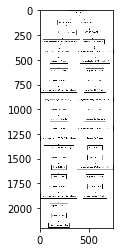

In [31]:
import matplotlib.image as mpimg
img = mpimg.imread('model.png')
img_plot = plt.imshow(img)
plt.show()

# Model Training

In [0]:
from keras.optimizers import Adam

In [0]:
losses = {
    "category_output" : "categorical_crossentropy",
    "color_output" : "categorical_crossentropy"
}

In [0]:
loss_weights = {
    'category_output': 1.0,
    'color_output': 1.0
}

In [0]:
opt = Adam(lr=init_lr, decay=init_lr / epochs)

In [0]:
model.compile(optimizer=opt, loss=losses, loss_weights=loss_weights, metrics=["accuracy"])

# Model branched Training

In [38]:
H = model.fit(
    x_train,
    {'category_output': y_train_cat, "color_output":y_train_col},
    validation_data=(
        x_test,
        {'category_output': y_test_cat, "color_output": y_test_col}
    ),
    epochs=epochs,
    verbose=1
)

Instructions for updating:
Use tf.cast instead.
Train on 1963 samples, validate on 491 samples
Epoch 1/50
1963/1963 [==============================] - 11s 6ms/step - loss: 1.3733 - category_output_loss: 1.0099 - color_output_loss: 0.3634 - category_output_acc: 0.7534 - color_output_acc: 0.8742 - val_loss: 0.8362 - val_category_output_loss: 0.6465 - val_color_output_loss: 0.1897 - val_category_output_acc: 0.8208 - val_color_output_acc: 0.9328
Epoch 2/50
1963/1963 [==============================] - 4s 2ms/step - loss: 0.6848 - category_output_loss: 0.5113 - color_output_loss: 0.1735 - category_output_acc: 0.8273 - color_output_acc: 0.9358 - val_loss: 0.5431 - val_category_output_loss: 0.4483 - val_color_output_loss: 0.0948 - val_category_output_acc: 0.8391 - val_color_output_acc: 0.9613
Epoch 3/50
1963/1963 [==============================] - 4s 2ms/step - loss: 0.5277 - category_output_loss: 0.3903 - color_output_loss: 0.1373 - category_output_acc: 0.8594 - color_output_acc: 0.9491 - val

In [0]:
# plot for losses

loss_names = ["loss", "category_output_loss", "color_output_loss"]
plt.style.use("ggplot")

(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

# loop over the loss names
for (i, l) in enumerate(loss_names):
  title = "Loss for {}".format(l) if l != "loss" else "Total loss"
  ax[i].set_title(title)
  ax[i].set_xlabel("Epoch #")
  ax[i].set_ylabel("loss")
  ax[i].plot(np.arange(0, epochs), H.history[l], label=l)
  ax[i].plot(np.arange(0, epochs), H.history["val_"+ l], label="val_"+l)
  ax[i].legend()

# save the losses
plt.tight_layout()
plt.savefig("{}_losses.png".format('multi'))
plt.close()

In [0]:
# plot for accuracy

acc_names = ["category_output_acc", 'color_output_acc']
plt.style.use("ggplot")
(fig, ax) = plt.subplots(2, 1, figsize=(8, 8))

for (i, l) in enumerate(acc_names):
  ax[i].set_title("Accuracy for {}".format(l))
  ax[i].set_xlabel("Epoch #")
  ax[i].set_ylabel("Accuracy")
  ax[i].plot(np.arange(0, epochs), H.history[l], label=l)
  ax[i].plot(np.arange(0, epochs), H.history["val_"+ l], label="val_"+l)
  ax[i].legend()

plt.tight_layout()
plt.savefig("{}_acc.png".format('multi'))
plt.close()